<a href="https://colab.research.google.com/github/syunar/superai-ss3-level1-hackhathon/blob/main/superai_ss3_hack1_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pipeline:
-	Install dependencies
    - Kaggle -> download and submission
    - Numpy pandas -> to work with dataframe
    - Cv2 PIL matplotlib -> to work with image (read to numpy array and show)
- os glob -> to work with file path
- tensorflow.keras sklearn -> to work with DL and ML
-	Setting for kaggle api
-	Download dataset from kaggle
-	Split train data to -> train val and test
-	Create model by using VGG model which pre-trained from imagenet dataset
-	Then train model (fine-tuning) to 10 output using crossentropy as loss function
-	Deal with test dataset
    - Create crop function
    - Use crop function to create real test dataset
-	Predict to test dataset
-	Submission to kaggle


# Install Dependencies

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/superai_hackhaton1_image/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c hackathon-online-2022-image-processing

 98% 407M/415M [00:01<00:00, 280MB/s]
100% 415M/415M [00:01<00:00, 254MB/s]


In [ ]:
!unzip hackathon-online-2022-image-processing.zip

Archive:  hackathon-online-2022-image-processing.zip
replace IM_Submit.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace IM_Test.zipfile? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace IM_Train.zipfile? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!mkdir /content/zipfile
!unzip /content/IM_Test.zipfile -d /content/zipfile
!unzip /content/IM_Train.zipfile -d /content/zipfile

Archive:  /content/IM_Test.zipfile
  inflating: /content/zipfile/IM_Test.zipfile  
Archive:  /content/IM_Train.zipfile
  inflating: /content/zipfile/IM_Train.zipfile  


In [ ]:
!mkdir /content/dataset/
!unzip /content/zipfile/IM_Test.zipfile -d /content/dataset
!unzip /content/zipfile/IM_Train.zipfile -d /content/dataset
!rm -r /content/zipfile

Streaming output truncated to the last 5000 lines.
 extracting: /content/dataset/train/8/7820.1.png  
 extracting: /content/dataset/train/8/7825.1.png  
 extracting: /content/dataset/train/8/7827.2.png  
 extracting: /content/dataset/train/8/7828.0.png  
 extracting: /content/dataset/train/8/7832.0.png  
 extracting: /content/dataset/train/8/7832.1.png  
 extracting: /content/dataset/train/8/7833.1.png  
 extracting: /content/dataset/train/8/7838.1.png  
 extracting: /content/dataset/train/8/7840.0.png  
 extracting: /content/dataset/train/8/7841.1.png  
 extracting: /content/dataset/train/8/7850.1.png  
 extracting: /content/dataset/train/8/7853.2.png  
 extracting: /content/dataset/train/8/7867.0.png  
 extracting: /content/dataset/train/8/787.0.png  
 extracting: /content/dataset/train/8/7871.1.png  
 extracting: /content/dataset/train/8/7878.1.png  
 extracting: /content/dataset/train/8/7885.0.png  
 extracting: /content/dataset/train/8/789.1.png  
 extracting: /content/dataset/tra

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Create Model

In [ ]:
train_path = '/content/dataset/train'
height = 50
width = 50
batch_size = 150
seed = 42

In [ ]:
classes = { 0:'0',
            1:'1', 
            2:'2', 
            3:'3', 
            4:'4', 
            5:'5', 
            6:'6', 
            7:'7', 
            8:'8', 
            9:'9'}

## Train Test Split

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 58609 images belonging to 10 classes.
Found 14648 images belonging to 10 classes.


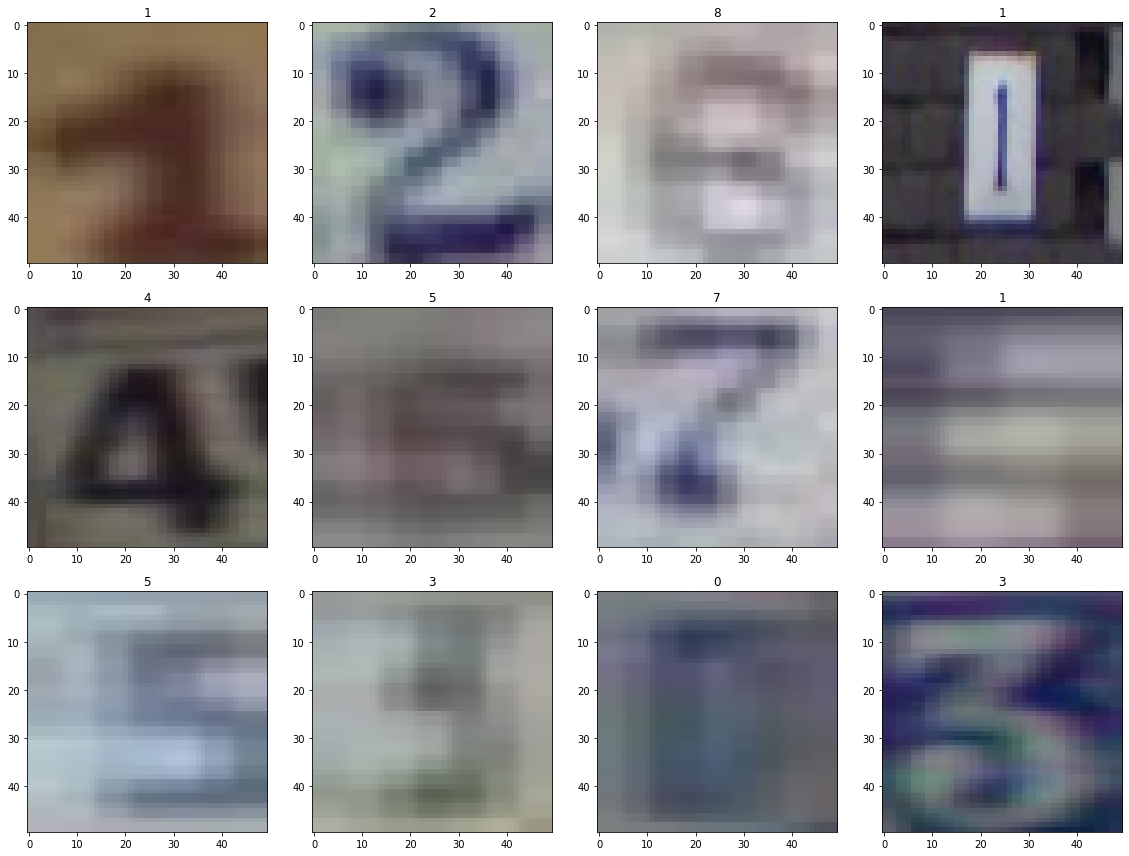

In [ ]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

## use vgg pretrained model

In [ ]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(10, activation='softmax')
                                ])

vgg_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_3 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 20,294,218
Trainable params: 20,293,194
N

## train model

In [ ]:
alpha=0.0001
epochs=20
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/20
391/391 [==============================] - 86s 188ms/step - loss: 0.4625 - accuracy: 0.8593 - val_loss: 0.3504 - val_accuracy: 0.8948
Epoch 2/20
391/391 [==============================] - 72s 185ms/step - loss: 0.2451 - accuracy: 0.9272 - val_loss: 0.2551 - val_accuracy: 0.9245
Epoch 3/20
391/391 [==============================] - 72s 183ms/step - loss: 0.1959 - accuracy: 0.9426 - val_loss: 0.2728 - val_accuracy: 0.9237
Epoch 4/20
391/391 [==============================] - 72s 183ms/step - loss: 0.1557 - accuracy: 0.9548 - val_loss: 0.2486 - val_accuracy: 0.9272
Epoch 5/20
391/391 [==============================] - 72s 184ms/step - loss: 0.1266 - accuracy: 0.9641 - val_loss: 0.2565 - val_accuracy: 0.9308
Epoch 6/20
391/391 [==============================] - 72s 183ms/step - loss: 0.0972 - accuracy: 0.9723 - val_loss: 0.3021 - val_accuracy: 0.9211
Epoch 7/20
391/391 [==============================] - 72s 184ms/step - loss: 0.0756 - accuracy: 0.9787 - val_loss: 0.2831 - val_ac

# Working with test dataset

In [ ]:
import pandas as pd
import json
from pandas import json_normalize

In [ ]:
with open('/content/dataset/IM_Test/IM_Test.json', encoding='utf8') as f:
    s = f.read()

In [ ]:
d = json.loads(s)

In [ ]:
pd.DataFrame(d)

,filename,bboxes
0,1.png,"[{'bbox_id': 0, 'x1': 43, 'x2': 62, 'y1': 7, '..."
1,2.png,"[{'bbox_id': 0, 'x1': 99, 'x2': 113, 'y1': 5, ..."
2,3.png,"[{'bbox_id': 0, 'x1': 61, 'x2': 72, 'y1': 6, '..."
3,4.png,"[{'bbox_id': 0, 'x1': 32, 'x2': 46, 'y1': 6, '..."
4,5.png,"[{'bbox_id': 0, 'x1': 97, 'x2': 116, 'y1': 28,..."
...,...,...
13063,13064.png,"[{'bbox_id': 0, 'x1': 227, 'x2': 249, 'y1': 43..."
13064,13065.png,"[{'bbox_id': 0, 'x1': 67, 'x2': 82, 'y1': 14, ..."
13065,13066.png,"[{'bbox_id': 0, 'x1': 33, 'x2': 45, 'y1': 19, ..."
13066,13067.png,"[{'bbox_id': 0, 'x1': 113, 'x2': 126, 'y1': 14..."


## Create dataframe to use for crop image function

In [ ]:
data = []
for img in range(0,len(d)):
    filename = d[img]['filename']
    for bbox in range(0,len(d[img]['bboxes'])):
        bbox_id = d[img]['bboxes'][bbox]['bbox_id']
        x1 = d[img]['bboxes'][bbox]['x1']
        x2 = d[img]['bboxes'][bbox]['x2']
        y1 = d[img]['bboxes'][bbox]['y1']
        y2 = d[img]['bboxes'][bbox]['y2']
        data.append({'filename': filename,
                    'bbox_id': bbox_id,
                    'x1': x1,
                    'x2': x2,
                    'y1': y1,
                    'y2': y2})

In [ ]:
df = (pd.DataFrame(data)
        .assign(filenum=lambda df_:df_.filename.str.split('.').str[0],
         imageid_boxid=lambda df_:df_.filenum.astype('str') + '_' + df_.bbox_id.astype('str')))
df

,filename,bbox_id,x1,x2,y1,y2,filenum,imageid_boxid
0,1.png,0,43,62,7,37,1,1_0
1,2.png,0,99,113,5,28,2,2_0
2,2.png,1,114,122,8,31,2,2_1
3,2.png,2,121,133,6,29,2,2_2
4,3.png,0,61,72,6,22,3,3_0
...,...,...,...,...,...,...,...,...
26027,13067.png,0,113,126,14,34,13067,13067_0
26028,13067.png,1,124,137,14,34,13067,13067_1
26029,13067.png,2,133,149,13,33,13067,13067_2
26030,13068.png,0,36,47,9,31,13068,13068_0


In [ ]:
def cropImg(df):
    test_dir = '/content/dataset/test'
    if os.path.isdir(test_dir) == False:
        os.makedirs(test_dir)

    for idx in range(0,df.shape[0]):
        img_dir = f'/content/dataset/IM_Test/IM_Test/{df.iloc[idx].filename}'
        img = cv2.imread(img_dir)
        cv2.imwrite(f"{test_dir}/{df.iloc[idx].imageid_boxid}.png",img[df.iloc[idx].y1:df.iloc[idx].y2,df.iloc[idx].x1:df.iloc[idx].x2])

        percent = round((idx+1) * 100 / df.shape[0],2)

        print(f'count_img = {idx+1}, {percent}%')



In [ ]:
#!rm -r /content/dataset/test
cropImg(df)

Streaming output truncated to the last 5000 lines.
count_img = 21033, 80.8%
count_img = 21034, 80.8%
count_img = 21035, 80.8%
count_img = 21036, 80.81%
count_img = 21037, 80.81%
count_img = 21038, 80.82%
count_img = 21039, 80.82%
count_img = 21040, 80.82%
count_img = 21041, 80.83%
count_img = 21042, 80.83%
count_img = 21043, 80.84%
count_img = 21044, 80.84%
count_img = 21045, 80.84%
count_img = 21046, 80.85%
count_img = 21047, 80.85%
count_img = 21048, 80.85%
count_img = 21049, 80.86%
count_img = 21050, 80.86%
count_img = 21051, 80.87%
count_img = 21052, 80.87%
count_img = 21053, 80.87%
count_img = 21054, 80.88%
count_img = 21055, 80.88%
count_img = 21056, 80.89%
count_img = 21057, 80.89%
count_img = 21058, 80.89%
count_img = 21059, 80.9%
count_img = 21060, 80.9%
count_img = 21061, 80.9%
count_img = 21062, 80.91%
count_img = 21063, 80.91%
count_img = 21064, 80.92%
count_img = 21065, 80.92%
count_img = 21066, 80.92%
count_img = 21067, 80.93%
count_img = 21068, 80.93%
count_img = 21069, 

## Predict test dataset

In [ ]:
def createTestFeature():
    test_dir = '/content/dataset/test'
    test_img_path = glob(f'{test_dir}/*')

    data = []
    img_test = []
    for img in test_img_path:
        image = cv2.imread(img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
        img_test.append(img)
    
    X_test = np.array(data)
    X_test = X_test/255

    return X_test, img_test

In [ ]:
X_test, img_test = createTestFeature()

In [ ]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]

In [ ]:
pred = vgg_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))

814/814 [==============================] - 13s 15ms/step


In [ ]:
len(pred)

26032

In [ ]:
result = {'path':img_test,
             'pred':pred}
df_result = pd.DataFrame(result)
df_result

,path,pred
0,/content/dataset/test/11303_1.png,5
1,/content/dataset/test/124_0.png,7
2,/content/dataset/test/4423_0.png,1
3,/content/dataset/test/2191_1.png,0
4,/content/dataset/test/6975_2.png,5
...,...,...
26027,/content/dataset/test/3663_0.png,1
26028,/content/dataset/test/2688_0.png,7
26029,/content/dataset/test/11166_1.png,0
26030,/content/dataset/test/10443_1.png,7


In [ ]:
(df_result
 .assign(imageid_boxid=lambda df_:df_.path.str.extract(r'(\d+_\d+)'))
 .drop('path', axis=1)
 .set_index('imageid_boxid')
)

,pred
imageid_boxid,
11303_1,5
124_0,7
4423_0,1
2191_1,0
6975_2,5
...,...
3663_0,1
2688_0,7
11166_1,0


## Submission

In [ ]:
df_submit = pd.read_csv('/content/IM_Submit.csv')

In [ ]:
submission = ((df_submit
.set_index('imageid_boxid')
).join(df_result
 .assign(imageid_boxid=lambda df_:df_.path.str.extract(r'(\d+_\d+)'))
 .drop('path', axis=1)
 .set_index('imageid_boxid')
)
.drop('class', axis=1)
.rename(columns={'pred':'class'})
)

In [ ]:
submission.to_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c hackathon-online-2022-image-processing -f submission.csv -m "hello kaggle"

100% 233k/233k [00:03<00:00, 62.9kB/s]
Successfully submitted to Hackathon Online: Image Processing